In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import os

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

# Normalization

## Impact of Individual Attributes

**We may be interested in understanding the impact of individual attributes**

<center><img src="assets/taiwan-tea-house.jpg" style="height: 400px;"></center>

* E.g. is the price more impacted by age, distance from MRT stations, or what? 


## A Straightforward Approach

**Let's start by repeating our basic linear regression approach**

In [2]:
data = pd.read_csv(os.path.join('..', 'data', 'real_estate.csv'), sep=',')
cols = data.columns
X = data[cols[:-1]]
y = np.log(data[cols[-1]])
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=42)
m = LinearRegression()
m.fit(X_tr, y_tr);
y_pred_tr, y_pred_ts = m.predict(X_tr), m.predict(X_ts)
print(f'R2: {r2_score(y_tr, y_pred_tr):.3} (training), {r2_score(y_ts, y_pred_ts):.3} (test)')

R2: 0.691 (training), 0.645 (test)


* We load the dataset, separate input & output, split the training and test set
* The we fit the model and evaluate the results

## A Straightforward Approach

**We can think of _looking at the coefficients_**

## A Straightforward Approach

**We can think of _looking at the coefficients_**

Intuitively:

* The higher the (absolute) weight, the more important the attribute
* A positive coefficient corresponds to a positive correlation (w.r.t. the price)
* A negative coefficient corresponds to a negative correlation

**We can obtain the coefficient from the `LinearRegression` object**

In [3]:
coeffs = m.coef_
print(m.coef_)

[-5.90006836e-03 -1.46649001e-04  3.06500063e-02  7.25153077e+00
  2.65552235e-01]


Then we can sort them by decreasing absolute value:

In [4]:
idx = np.argsort(-np.abs(coeffs)) # Sort indexes by decreasing absolute coefficient
scores = m.coef_[idx] # Coefficients, in the order defined by idx

## A Straightforward Approach

**We can show the results via a bar chart**

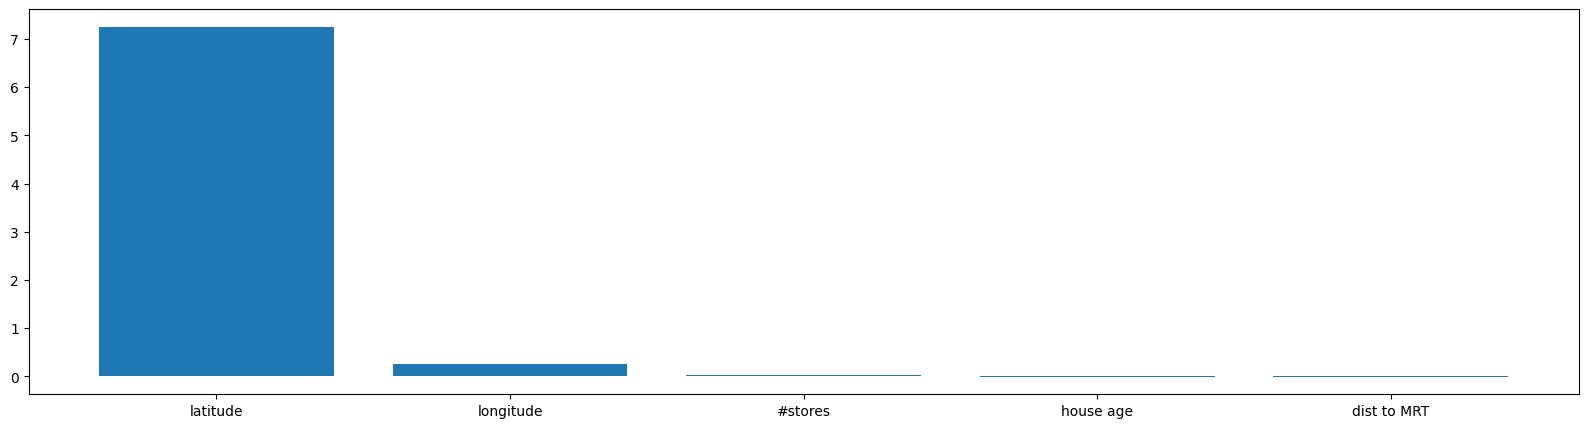

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(0.5 + np.arange(len(idx)), scores, tick_label=X.columns[idx]);

* The plot seems to suggest that "latitude" has by far the largest impact
* ...But that does not match with our original dataset inspection!

## A Straightforward Approach

**There is a (huge) pitfall with this approach**

* Each coefficient depends on the attribute importance, but also on its scale
* I.e. an attribute with _larger values_ may end up with a _smaller coefficient_

**A possible solution consists in preprocessing the data**

...So that all inputs have _similar scale_

* A first common approach: normalization (all values in the 0-1 range)
$$
x^\prime = \frac{x - \min(x)}{\max(x) - \min(x)}
$$
* A second one: standardization (the mean becomes 0, the st. dev. becomes 1)
$$
x^\prime = \frac{x - \text{mean}(x)}{\text{std}(x)}
$$

## Normalization/Standardization

**scikit-learn provides simple tools to take care of this step**

The are called `MinMaxScaler` and `StandardScaler`:

In [7]:
from sklearn.preprocessing import StandardScaler # for standardization

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)

**On the training set:**

* We calibrate the scaler (i.e. compute the mean and st. dev.)
* The we apply the transformation

In [9]:
X_ts_s = scaler.transform(X_ts)

**On the test set we simply apply the transformation**

* We do not want information about the test data to "leak" into the model

## The Correct Approach

**We can then repeat the process using the scaled data**

In [10]:
m = LinearRegression()
m.fit(X_tr_s, y_tr);

y_pred_ts = m.predict(X_ts_s)
print(f'R2 on the test set: {r2_score(y_ts, y_pred_ts):.3}')

R2 on the test set: 0.645


* The quality of the predictions is the same as before
* ...Since we have applied only a linear transformation to the input

## The Correct Approach

**Now we can build and inspect the same plot as before**

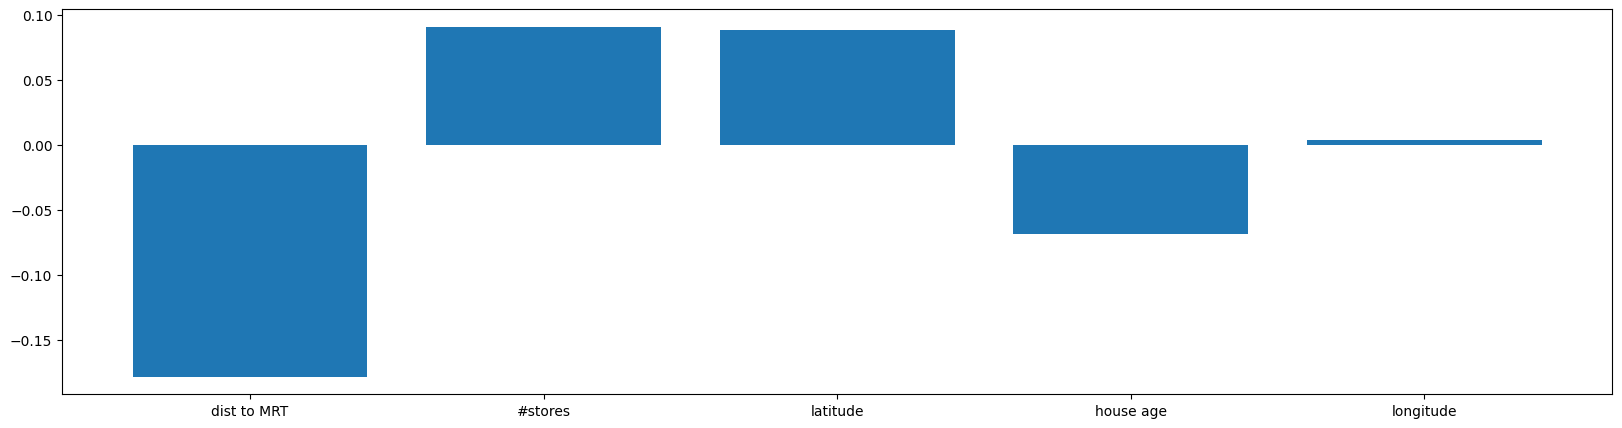

In [12]:
idx = np.argsort(-np.abs(m.coef_))
scores_s = m.coef_[idx]
plt.figure(figsize=(20, 5))
plt.bar(0.5 + np.arange(len(idx)), scores_s, tick_label=X.columns[idx]);

* The order of the attributes has changed!

# LASSO

## Attribute Selection

**Let's look again at the last plot**

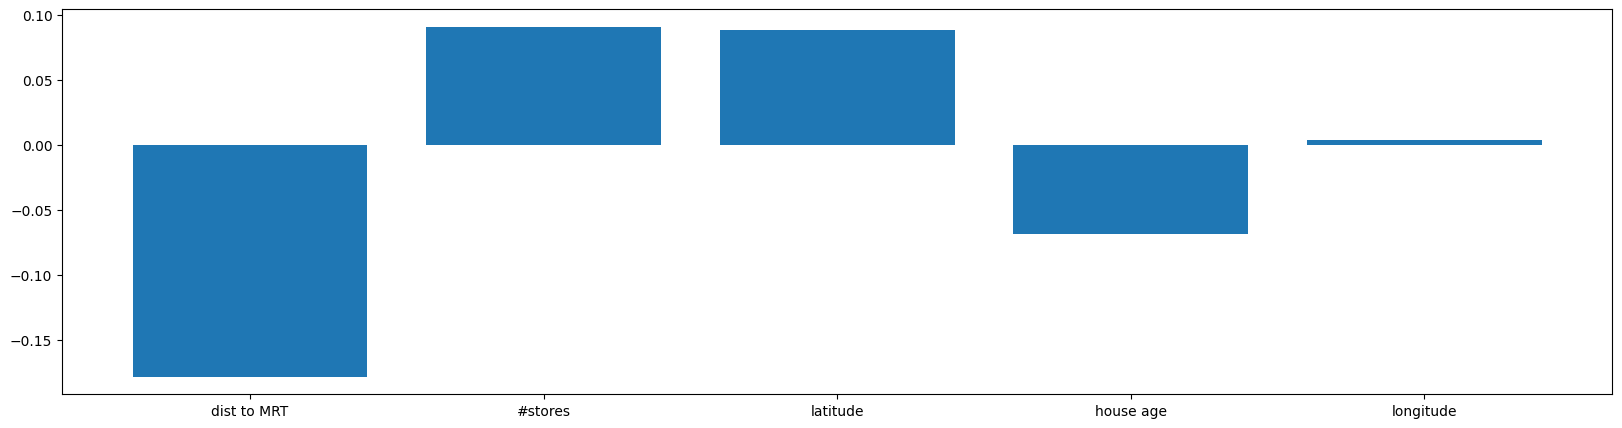

In [13]:
plt.figure(figsize=(20, 5))
plt.bar(0.5 + np.arange(len(idx)), scores_s, tick_label=X.columns[idx]);

* Is it worth keeping "longitude", given its low importance?
* Collecting useless attributes has still a cost!

## Attribute Selection

**Choosing which attributes to keep is known as _attribute selection_**

There are multiple solution approaches

* An exact (but costly) one: consider all possible sets and repeat training
* A cheap (but heuristic) one: remove attributes with small (abs.) coefficients

**In the case of linear regression, we have _a third option_**

We can _act on the structure of the loss (error) function_ used during training:
$$
L(w) = \mathit{MSE}(w) + \alpha \|w\|_1
$$

* Where $\|w\|_1 = \sum_{j=1}^n |w_j|$
* The additional term $\|w\|$ is introduced to make mode model "well behaved"
* ...And for this reason it is called a _reguralizer_
* In particular, since we are using the L1 norm, we call it an _L1 regularizer_

## LASSO

**At training time, we will need to solve**

$$
\text{argmin}_w \mathit{MSE}(w) + \alpha \|w\|_1
$$

For reasons not discussed in detail:

* If moving a coefficient away from 0 does not provide enough error improvement
* ...Then the attribute will not be used at all
* What "enough" means in practice depends on the value of $\alpha$

**As a result, we naturally end-up doing attribute selection**

The approach is known as _Least Absolute Shrinkage and Selection Operator_

* ...Or LASSO for short :-)

## Using LASSO

**Scikit-learn provides a convenient LASSO implementation**

In [14]:
from sklearn.linear_model import Lasso
m2 = Lasso(alpha=1.0)

* When building the model, we need to pick a value for $\alpha$
* Higher $\alpha$ values promote using fewer attributes
* ...But they also reduce the prediction quality

**For now, we will fix $\alpha$ via trial-and-error approach:**

In [15]:
m2.fit(X_tr_s, y_tr);
y_pred_tr2 = m2.predict(X_tr_s)
print(f'R2 on the training set: {r2_score(y_tr, y_pred_tr2):.3}')

R2 on the training set: 0.0


* This is too low, and therefore $\alpha = 1.0$ is too large

## Choosing $\alpha$

In [16]:
m2 = Lasso(alpha=0.1)
m2.fit(X_tr_s, y_tr);
y_pred_tr2 = m2.predict(X_tr_s)
print(f'R2 on the training set: {r2_score(y_tr, y_pred_tr2):.3}')

R2 on the training set: 0.549


* The prediction quality is still much lower than the original one

In [17]:
m2 = Lasso(alpha=0.05)
m2.fit(X_tr_s, y_tr);
y_pred_tr2 = m2.predict(X_tr_s)
print(f'R2 on the training set: {r2_score(y_tr, y_pred_tr2):.3}')

R2 on the training set: 0.643


* Now we are back to the original value (more or less)!

## Impact of Each Attribute

**Once we are satisfied with the $\alpha$ values, we can inspect the coefficients**

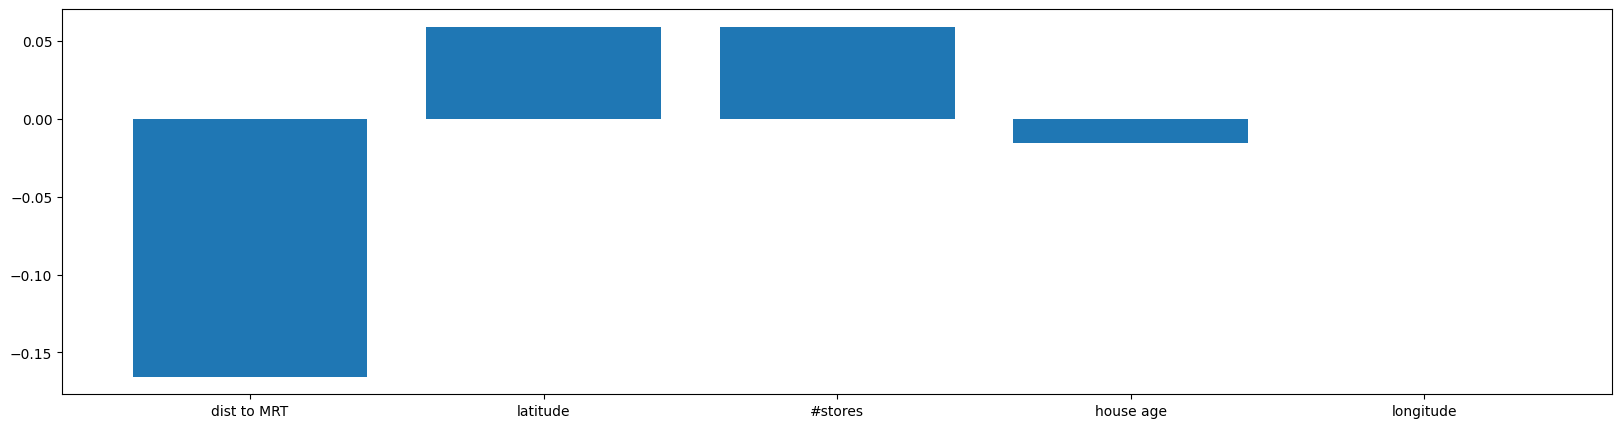

In [19]:
idx = np.argsort(-np.abs(m2.coef_))
scores = m2.coef_[idx]
plt.figure(figsize=(20, 5))
plt.bar(0.5 + np.arange(len(idx)), scores, tick_label=X.columns[idx]);

* The "longitude" attribute has been dropped
* When there are many attributes, the LASSO method can be extremely useful

# Ridge Regression

## Overfitting

**We have already observed how our model has a modest degree of overfitting**

In [20]:
print(f'R2 on the training set (linear regression): {r2_score(y_tr, y_pred_tr):.3}')
print(f'R2 on the test set (linear regression): {r2_score(y_ts, y_pred_ts):.3}')

R2 on the training set (linear regression): 0.691
R2 on the test set (linear regression): 0.645


**Overfitting arises when:**

* The model learns patterns in the training set
* ...That do not repeat on unseen data (e.g. since they due to random sampling)

**This becomes more critical with many attributes and scarce data**

* A linear regression model with $n$ coefficients
* ...Can interpolate perfectly any collections of $n$ examples
* ...But typically, that means we are just learning noise :-(

## First, Let's Make It Worse

**First, let's amplify the problem, so as to make any change more significant**

In particular, we will reduce the amount of available training data

In [21]:
X_tr2, X_ts2, y_tr2, y_ts2 = train_test_split(X, y, test_size=0.938, random_state=42)

scaler2 = StandardScaler()
X_tr_s2 = scaler2.fit_transform(X_tr2)
X_ts_s2 = scaler2.transform(X_ts2)
print(f'Training set size: {len(X_tr_s2)}')

m3 = LinearRegression()
m3.fit(X_tr2, y_tr2)

y_pred_tr3, y_pred_ts3 = m3.predict(X_tr2), m3.predict(X_ts2)
print(f'R2: {r2_score(y_tr2, y_pred_tr3):.3} (training), {r2_score(y_ts2, y_pred_ts3):.3} (test)')

Training set size: 25
R2: 0.628 (training), 0.509 (test)


* Having access to little data is not uncommon
* Input are easy to obtain, but targets are often expensive to collect

## Ridge Regression

**We will show how to reduce overfitting by using _ridge regression_**

...Which is obtained from linear regression by adding a quadratic reguralizer:
$$
\text{argmin}_\theta \mathit{MSE}(w) + \alpha \|w\|_2^2
$$
where $\|w\|_2^2 = \sum_{j=1}^2 w_j^2$

* Since the $\|w\|_2$ is an L2 norm, this is called an _L2 regularizer_
* It looks similar to the L1 regularizer in the LASSO approach
* ...But it has a very different effect

**This regularizer _prevents weights from having a large absolute value_**

* Smaller (absolute) weights result in smoother behavior
* ...Which typically leads to better generalization

## Using Ridge Regression

**Scikit-learn provides an implementation for Ridge Regression**

In [22]:
from sklearn.linear_model import Ridge
m4 = Ridge(alpha=1.0)
m4.fit(X_tr_s2, y_tr2);

It works similarly to the `Lasso` class

* When we build the model, we need to specify a value for $\alpha$
* ...Then we train the model as usual

In [23]:
y_pred_tr4 = m4.predict(X_tr_s2)
y_pred_ts4 = m4.predict(X_ts_s2)
print(f'R2 on the training set: {r2_score(y_tr2, y_pred_tr4):.3}')
print(f'R2 on the test set: {r2_score(y_ts2, y_pred_ts4):.3}')

R2 on the training set: 0.627
R2 on the test set: 0.534


* The default value for $\alpha$ is 1.0
* ...And it is already helping a bit the model on unseen data

## Cross-Validation and Hyper-Parameter Tuning

**This time, we will follow a systematic approach to pick a value for $\alpha$**

* Our goal is to improve the model results on _unseen examples_
* So we can choose $\alpha$ to minimize the error on examples _not in the training set_

**It would be tempting to optimize $\alpha$ for the test set...**

...But it would also be _very wrong_

* The test set is our ultimate approach to assess generalization
* For this, its content _stay unseen_ whenever we calibrate parameters

**We can however split _yet another set_ on this purpose**

* This would not be used to train the model
* ...But only for tuning the training parameters (also called _hyper-parameters_)

**This is called a _validation set_**

* But there is a drawback: we have _even less data available for training_

## Cross-Validation and Hyper-Parameter Tuning

**As an alternative, we can use _$k$-fold cross-validation_:**

* We partition the training data in $k$ sets, called _folds_
* For $i = 1..k$:
  - We separate the $i$-th fold
  - We train a model on the remaining data
  - We evaluate the prediction quality on the separated fold
  - Then we put the fold back
  
During each iteration, the examples in the $i$-th folder are effectively unseen

**At the end of the process we have:**

* $k$ models (that typically we _don't_ use)
* $k$ prediction quality evaluations (of which we can take the mean)

We can use cross validation to _assess how good a model is with unseen data_

## Applying Cross-Validation and Hyper-Parameter Tuning

**Scikit learn allows us to automate this process with a few lines of code**

* First we specify which parameters we want to tune
* ...And which range we want to investigate

We do so by building a dictionary:

In [24]:
param_ranges = {'alpha': np.logspace(0, 2, 100)}

* The dictionary keys are the parameters to be tuned
* The entries are the values to be tested

Then we build a `GridSearchCV` object:

In [26]:
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(estimator=Ridge(), param_grid=param_ranges, cv=5)

* The `cv` parameter specifies the number of folds

## Applying Cross-Validation and Hyper-Parameter Tuning

**The we can "train" the `GridSearchCV` object**

* This will try all combinations of the values in parameter ranges
* ...And pick the parameters leading to the best cross-validation score

In [27]:
gscv.fit(X_tr_s2, y_tr2);

The best parameters can be accessed via the `best_params_` field:

In [28]:
print(','.join(f'{k} = {v:.4f}' for k, v in gscv.best_params_.items()))

alpha = 27.1859


## Applying Cross-Validation and Hyper-Parameter Tuning

**By default, the `GridSearchCV` object:**

* Trains an estimator with the best parameters _on all data_
* This is the model that we are going to use

Calling `predict` on `GridSearchCV` calls the same method on the best estimator:

In [29]:
y_pred_tr4 = gscv.predict(X_tr_s2)
y_pred_ts4 = gscv.predict(X_ts_s2)
print(f'R2 on the training set: {r2_score(y_tr2, y_pred_tr4):.3}')
print(f'R2 on the test set: {r2_score(y_ts2, y_pred_ts4):.3}')

R2 on the training set: 0.516
R2 on the test set: 0.638


* This is _close to our original approach_ on unseen data
* ...Even if we are using _only 25 data points_!

## Conclusions and Take-Home Messages

* Attribute normalization to improve interpretability
  - Linear Regression is a rather _interpretable_ ML model...
  - ...Provided that attributes are processed to have a _similar scale_
* L1 regularization
  - L1 regularization can be employed for automatic _attribute selection_
  - ...And it also helps _reducing overfitting_
* L2 regularization
  - L2 regularization is mostly about _reducing overfitting_
  - ...But for that it works _better than L1_ regularization
* (Cross)-validation
  - Validation data can be used to _calibrate hyper-parameters_
  - ...Such as the regularization weights
  - Cross-validation enables a _more efficient_ use of data